In [1]:
suppressMessages(library(scran))
library(BiocParallel)
library(parallel)
library(muscat)
suppressMessages(library(limma))
suppressMessages(library(EnhancedVolcano))
suppressMessages(library(patchwork))
suppressMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressWarnings(library(iTALK))
library(RColorBrewer)
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))

Registered S3 method overwritten by 'gamlss':
  method   from
  print.ri bit 



In [2]:
performDET=function(seuratobj_sub, kid="WNN_agg"){
pbmc.sce <- as.SingleCellExperiment(seuratobj_sub)
pbmc.sce=prepSCE(
  pbmc.sce,
  kid = kid,
  sid = "orig.ident",
  gid = "response",
  drop = T
)
pb <- aggregateData(pbmc.sce,
                    assay = "counts", fun = "sum",
                    by = c("cluster_id", "sample_id"),
                    BPPARAM = MulticoreParam(workers=8)
                   )
design_mat=model.matrix(~0+group_id,colData(pb))
contrast=makeContrasts(group_idnonCR-group_idCR,levels=design_mat)
res_deseq2_post=pbDS(pb,
                     method = "DESeq2",
                     design = design_mat,
                     contrast = contrast,
                     min_cells = 10,  
                     treat = FALSE,
                     verbose = TRUE,
                     BPPARAM = MulticoreParam(workers=8)
                    )
}

In [3]:
FilterandSplit=function(res_post, qthreshold=0.05, logFCthreshold){
    res_post_tables=res_post$table[[1]]
    restable_post=bind_rows(res_post_tables)
    restable_post=restable_post %>% select(gene, cell_type=cluster_id, logFC, p.value=p_val, q.value=p_adj.loc)
    if (logFCthreshold > 0){
    restable_post=restable_post %>% filter(q.value<qthreshold, logFC>logFCthreshold)
        }
    else {
        restable_post=restable_post %>% filter(q.value<qthreshold, logFC<logFCthreshold)
    }
    restable_post_splitted=restable_post %>% split(f = as.factor(.$cell_type))
}

In [4]:
getLRI=function(res_post_splitted){
comparison_grid=expand.grid(seq_along(res_post_splitted), seq_along(res_post_splitted))
res_post<-NULL
comm_list<-c('growth factor','other','cytokine','checkpoint')
for (i in seq(nrow(comparison_grid))){
    for(comm_type in comm_list){
res_cat<-FindLR(res_post_splitted[[comparison_grid$Var1[i]]],
                res_post_splitted[[comparison_grid$Var2[i]]],
                datatype='DEG',comm_type=comm_type)
        
        res_post<-rbind(res_post,res_cat)
        }
}
    return(res_post)
    }

In [99]:
# Function from iTalk with modified font size
LRPlot2<-function(data,datatype,gene_col=NULL,transparency=0.5,link.arr.lwd=1,link.arr.lty=NULL,link.arr.col=NULL,link.arr.width=NULL,
                 link.arr.type=NULL,facing='clockwise',cell_col=NULL,print.cell=TRUE,track.height_1=uh(2,'mm'),track.height_2=uh(12,'mm'),
                 annotation.height_1=0.01,annotation.height_2=0.01,text.vjust = '0.4cm',gene_size=1.2, celltype_size=1.5,...){
  cell_group<-unique(c(data$cell_from,data$cell_to))
  genes<-c(structure(data$ligand,names=data$cell_from),structure(data$receptor,names=data$cell_to))
  genes<-genes[!duplicated(paste(names(genes),genes))]
  genes<-genes[order(names(genes))]
  if(is.null(link.arr.lty)){
    if(datatype=='mean count'){
      link.arr.lty='solid'
    }else if(datatype=='DEG'){
      link.arr.lty=structure(ifelse(data$cell_from_logFC==0.0001,'dashed','solid'),names=paste(data$cell_from,data$receptor))
    }else{
      print('invalid datatype')
    }
  }
  if(is.null(link.arr.col)){
    if(datatype=='mean count'){
      data<-data %>% mutate(link_col='black')
    }else if(datatype=='DEG'){
      data<-data %>% mutate(link_col=ifelse(cell_from_logFC==0.0001,ifelse(cell_to_logFC>0,'#d73027','#00ccff'),
                                            ifelse(cell_to_logFC==0.0001,ifelse(cell_from_logFC>0,'#d73027','#00ccff'),
                                                   ifelse(cell_from_logFC>0,ifelse(cell_to_logFC>0,'#d73027','#dfc27d'),
                                                          ifelse(cell_to_logFC>0,'#9933ff','#00ccff')))))
    }else{
      print('invalid datatype')
    }
  }else{
    data$link_col=link.arr.col
  }
  if(is.null(link.arr.type)){
    if(datatype=='mean count'){
      link.arr.type='triangle'
    }else if(datatype=='DEG'){
      link.arr.type=structure(ifelse(data$cell_to_logFC==0.0001,'ellipse','triangle'),names=paste(data$cell_from,data$receptor))
    }else{
      print('invalid datatype')
    }
  }
  if(is.null(gene_col)){
    comm_col<-structure(c('#99ff99','#99ccff','#ff9999','#ffcc99'),names=c('other','cytokine','checkpoint','growth factor'))
    gene_col<-structure(c(comm_col[data$comm_type],rep('#073c53',length(data$receptor))),names=c(data$ligand,data$receptor))
  }
  if(is.null(cell_col)){
    cell_col<-structure(randomColor(count=length(unique(names(genes))),luminosity='dark'),names=unique(names(genes)))
  }
  if(is.null(link.arr.lwd)){
    data<-data %>% mutate(arr_width=1)
  }else if(max(abs(link.arr.lwd))-min(abs(link.arr.lwd))==0 && all(link.arr.lwd!=0.0001)){
    data<-data %>% mutate(arr_width=ifelse(abs(link.arr.lwd<5),abs(link.arr.lwd),5))
  }else{
    data<-data %>% mutate(arr_width=ifelse(link.arr.lwd==0.0001,2,1+5/(max(abs(link.arr.lwd))-min(abs(link.arr.lwd)))*(abs(link.arr.lwd)-min(abs(link.arr.lwd)))))
  }
  if(length(cell_group)!=1){
    gap.degree <- do.call("c", lapply(table(names(genes)), function(i) c(rep(1, i-1), 8)))
  }else{
    gap.degree <- do.call("c", lapply(table(names(genes)), function(i) c(rep(1, i))))
  }
  circos.par(gap.degree = gap.degree)
  if(length(gene_col)==1){
    grid.col=gene_col
  }else{
    grid.col=gene_col[genes]
    names(grid.col)<-paste(names(genes),genes)
  }
  if(is.null(link.arr.width)){
    data<-data %>% mutate(link.arr.width=data$arr_width/10)
  }else if(max(abs(link.arr.width))-min(abs(link.arr.width))==0 && all(link.arr.width!=0.0001)){
    data<-data %>% mutate(link.arr.width=ifelse(abs(link.arr.width)<0.5,abs(link.arr.width),0.5))
  }else{
    data<-data %>% mutate(link.arr.width=ifelse(link.arr.width==0.0001,0.2,(1+5/(max(abs(link.arr.width))-min(abs(link.arr.width)))*(abs(link.arr.width)-min(abs(link.arr.width))))/10))
  }
  chordDiagram(as.data.frame(cbind(paste(data$cell_from,data$ligand),paste(data$cell_to,data$receptor))), order=paste(names(genes),genes),
               grid.col=grid.col,transparency=transparency,directional=1,direction.type='arrows',link.arr.lwd=data$arr_width,link.arr.lty=link.arr.lty,
               link.arr.type=link.arr.type,link.arr.width=data$link.arr.width,link.arr.col=data$link_col,col='#00000000',annotationTrack=c('grid'),preAllocateTracks = list(
                 list(track.height = track.height_1),list(track.height = track.height_2)),annotationTrackHeight = c(annotation.height_1,annotation.height_2),...)

  circos.trackPlotRegion(track.index = 2, panel.fun = function(x, y) {
    xlim = get.cell.meta.data("xlim")
    ylim = get.cell.meta.data("ylim")
    sector.index = genes[get.cell.meta.data("sector.numeric.index")]
    circos.text(mean(xlim),mean(ylim),sector.index, col = "black", cex = gene_size, facing = facing, niceFacing = TRUE) #Change fontsize here
  }, bg.border = 0)

  if(print.cell){
    for(c in unique(names(genes))) {
      gene = as.character(genes[names(genes) == c])
      highlight.sector(sector.index = paste(c,gene), track.index = 1, col = ifelse(length(cell_col)==1,cell_col,cell_col[c]), text = c, 
                       text.vjust = text.vjust, niceFacing = TRUE,lwd=1, cex = celltype_size)
    }
  }
  circos.clear()
}

In [5]:
seuratobj_full=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.rds')

In [6]:
#Preprocess seuratobj_full
seuratobj_full=DietSeurat(
  seuratobj_full,
  counts = TRUE,
  data = T,
  scale.data = FALSE,
  features = NULL,
  assays = 'RNA',
  dimreducs = F,
  graphs = F
)

#seuratobj_full <- NormalizeData(seuratobj_full, normalization.method = "CLR", margin = 2, assay = "ADT")
seuratobj_full@meta.data=seuratobj_full@meta.data %>% 
mutate(timepoint=ifelse(days.since.apharesis<2, 'apharesis','post_infusion')) %>%
unite(orig.ident.WNN_l2, orig.ident, WNN_l2, remove=F) 

seuratobj_full$idecabtagene_pos=GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['idecabtagene',]>0
seuratobj_full$ciltacabtagene_pos=GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['ciltacabtagene',]>0

genenames=rownames(seuratobj_full)

IGHVgenes=genenames[grep('^IGHV', genenames)]
IGLVgenes=genenames[grep('^IGK|^IGL', genenames)]
TRgenes=genenames[grep('^TR(B|A)V', genenames)]
CARgenes=c('ciltacabtagene', 'idecabtagene')
sexgenes=c('XIST', 'RPS4Y1', 'RPS4Y2')

informative_genes=setdiff(genenames, Reduce(union, list(IGHVgenes, IGLVgenes, TRgenes, sexgenes, CARgenes)))
seuratobj_full=seuratobj_full[informative_genes, ] 

In [7]:
#Classify PR as nonCR
seuratobj_full@meta.data=seuratobj_full@meta.data %>% mutate(response=ifelse(remission.after.CAR=='CR', 'CR', 'nonCR'))

In [8]:
#subset for non CART and main cell types
seuratobj=seuratobj_full[informative_genes,                       
                        seuratobj_full$WNN_agg!='Others'&
                        seuratobj_full$idecabtagene_pos==F&
                         seuratobj_full$ciltacabtagene_pos==F
                       ]

# Identifying Cell-cell interaction  with iTALK

## nonCR vs CR 
First we identify the DEGs between nonCR and CR samples across each cell types using pseudobulk method. These DEGS are subsetted for any ligand receptor genes and then plotted using iTALK. 

### Pre-manufacture PBMCs 
Here we identify upregulated/downregulated ligand-receptor interactions in nonCR patients vs CR patients for pre-manufacture PBMCs.

The arrows point from ligands to receptors. Red arrow means the ligand-receptor pair is upregulated in nonCR vs CR, while blue arrow means downregulated. Thickness of the arrow line corresponds to how much the ligand is up/downregulated in nonCR vs CR, while size of the arrow head corresponds to how much the receptor is up/downregulated in nonCR vs CR.

In [9]:
seuratobj_sub=seuratobj[,
                        seuratobj$source=='PB'&
                        seuratobj$timepoint=='apharesis'
                       ]

In [10]:
res_pre=performDET(seuratobj_sub)

In [11]:
res_pre_up_splitted=FilterandSplit(res_pre, qthreshold=0.05, logFCthreshold=0.5)
pre_up_LRI=getLRI(res_pre_up_splitted)

In [12]:
res_pre_down_splitted=FilterandSplit(res_pre, qthreshold=0.05, logFCthreshold=-0.5)
pre_down_LRI=getLRI(res_pre_down_splitted)

In [19]:
pre_LRI=bind_rows(pre_up_LRI, pre_down_LRI) %>% distinct

In [128]:
# discrete
lgd_lines = Legend(at = c("Upregulated in non-CR", "Downregulated in non-CR"), type = "lines", 
                   legend_gp = gpar(col =c('#d73027','#00ccff'), lwd = 4),
                   labels_gp =  gpar(fontsize = 12, fontface = "bold"),
                   title_position = "topleft")

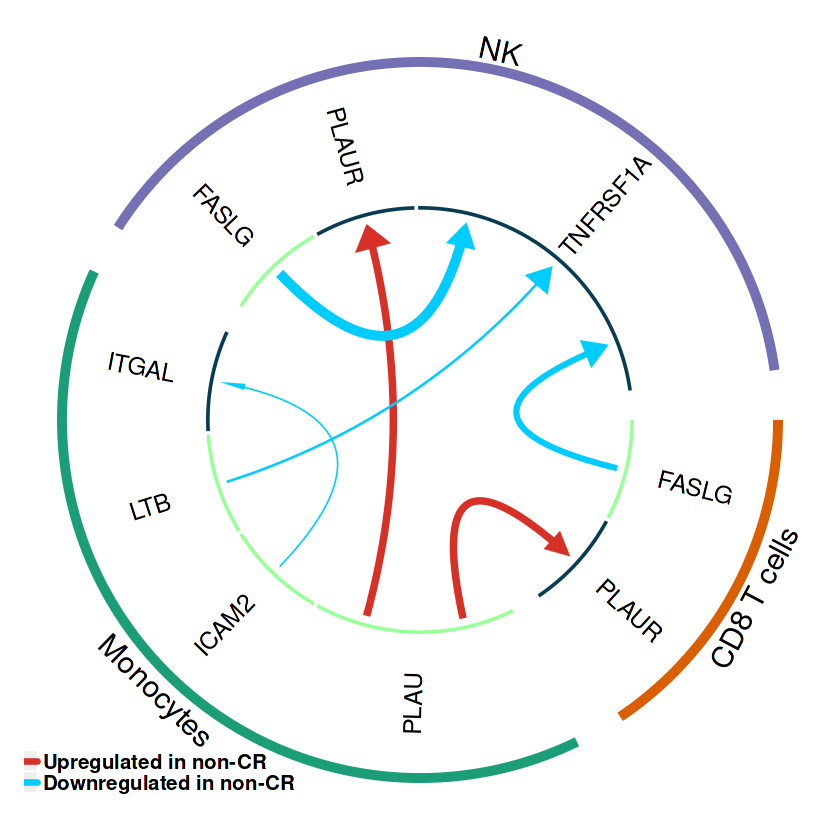

In [129]:
options(repr.plot.width=7, repr.plot.height=7)
cell_col<-structure(brewer.pal(n=3,"Dark2"),names=unique(c(pre_LRI$cell_from, pre_LRI$cell_to)))
p=LRPlot2(pre_LRI,datatype='DEG',cell_col=cell_col, track.height_2=uh(25,'mm'), 
         link.arr.lwd=pre_LRI$cell_from_logFC,link.arr.width=pre_LRI$cell_to_logFC, gene_size=1.2)
draw(lgd_lines, x = unit(4, "mm"), y = unit(10, "mm"), just = c("left", "bottom") )